# Embedding Visualization
Visualize 2D projections of intent embeddings using UMAP/TSNE.


In [7]:
from pathlib import Path
import sys

cwd = Path.cwd()
project_root = cwd.parent if cwd.name == 'notebooks' else cwd
sys.path.insert(0, str(project_root))


In [8]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from training.config import IntentEmbeddingConfig
from models.intent_embedder import ToolIntentEmbedder
from models.projection_head import ProjectionHead
from training.data_generator import NaturalLanguageToolCallGenerator, OutputFormat


In [9]:
config = IntentEmbeddingConfig()
if not torch.cuda.is_available():
    raise RuntimeError('CUDA is required for this notebook.')
device = torch.device('cuda')
dtype_map = {
    'float16': torch.float16,
    'bfloat16': torch.bfloat16,
    'float32': torch.float32,
}
model_torch_dtype = config.torch_dtype
proj_dtype = dtype_map.get(model_torch_dtype, torch.float32)
ckpt_path = project_root / 'checkpoints' / 'best_model.pt'

intent_embedder = ToolIntentEmbedder(
    model_name=config.encoder_model,
    embedding_dim=config.intent_embedding_dim,
    pooling_strategy=config.pooling_strategy,
    dropout=config.dropout,
    freeze_base=config.freeze_encoder,
    freeze_layers=config.freeze_encoder_layers,
    torch_dtype=model_torch_dtype,
    max_length=config.max_length,
).to(device)

projection_head = ProjectionHead(
    input_dim=config.intent_embedding_dim,
    output_dim=config.projection_dim,
    dropout=config.dropout,
).to(device).to(proj_dtype)

if ckpt_path.exists():
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    intent_embedder.load_state_dict(ckpt['intent_embedder_state_dict'])
    projection_head.load_state_dict(ckpt['projection_head_state_dict'])
    projection_head = projection_head.to(proj_dtype)
    print(f'Loaded checkpoint: {ckpt_path}')
else:
    print(f'Checkpoint not found at {ckpt_path}. Using random weights.')

intent_embedder.eval()
projection_head.eval()


Loaded checkpoint: /scratch4/home/akrik/NTILC/checkpoints/best_model.pt


ProjectionHead(
  (projection): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [10]:
generator = NaturalLanguageToolCallGenerator(output_format=OutputFormat.PYTHON)
num_samples = 800
data = [generator.generate_pair() for _ in range(num_samples)]

tool_calls = [d['tool_call_dict'] for d in data]
queries = [d['query'] for d in data]
labels = [d['tool'] for d in data]
label_names = sorted(set(labels))
label_to_id = {name: i for i, name in enumerate(label_names)}
label_ids = np.array([label_to_id[l] for l in labels])


In [12]:
batch_size = 64
all_embeddings = []

with torch.no_grad():
    for i in range(0, num_samples, batch_size):
        batch_calls = tool_calls[i:i+batch_size]
        batch_queries = queries[i:i+batch_size]
        intent_emb = intent_embedder(tool_calls=batch_calls, queries=batch_queries)
        proj_emb = projection_head(intent_emb.to(proj_dtype))
        all_embeddings.append(proj_emb.float().cpu().numpy())

embeddings = np.concatenate(all_embeddings, axis=0)


/scratch4/home/akrik/base/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


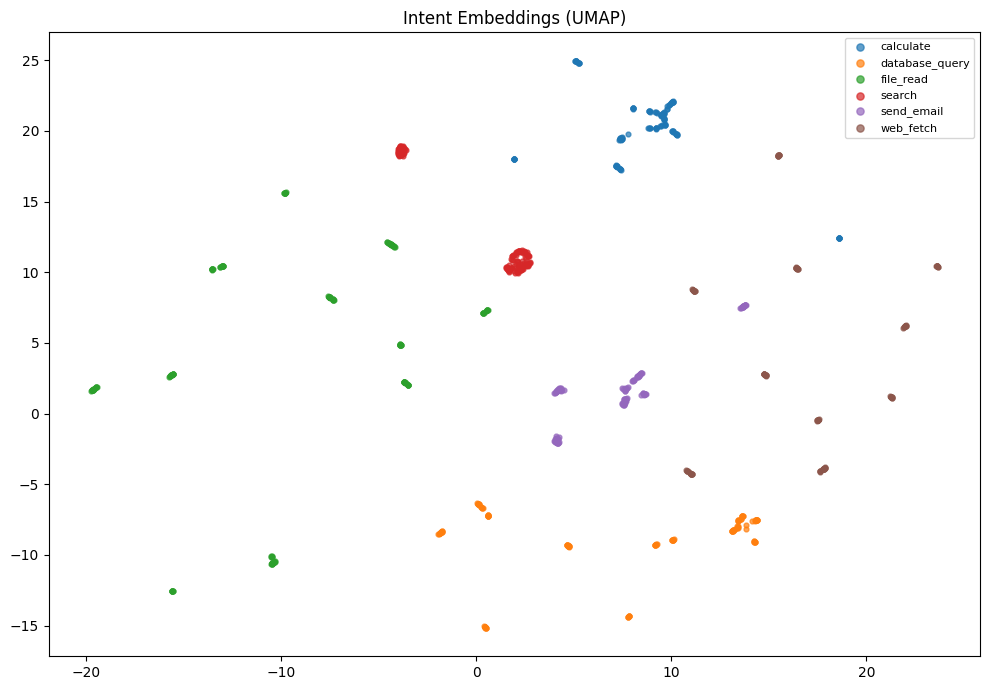

In [13]:
try:
    import umap
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, metric='cosine', random_state=42)
    coords = reducer.fit_transform(embeddings)
    method = 'UMAP'
except Exception:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
    coords = reducer.fit_transform(embeddings)
    method = 'TSNE'

plt.figure(figsize=(10, 7))
for name, idx in label_to_id.items():
    mask = label_ids == idx
    plt.scatter(coords[mask, 0], coords[mask, 1], s=12, alpha=0.7, label=name)
plt.title(f'Intent Embeddings ({method})')
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()
plt.show()
